In [113]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

from IPython.display import Audio

In [ ]:
## SFTF

In [2]:
# import a databank of sounds or import from audio

In [5]:
specs_syllables_df = pd.read_pickle("/data0/home/h21/luas6629/Thesis/DB_Isolated_segs_no_outliers.pkl")  

In [7]:
# Read the audio file
#audio_binary = tf.io.read_file('sample.wav')
#audio, sample_rate = tf.audio.decode_wav(audio_binary)
#audio = tf.squeeze(audio, axis=-1)

In [41]:
sample = specs_syllables_df.iloc[0].audio
sample_std = (sample - sample.mean()) / sample.std()

In [45]:
Audio(sample, rate=88200)

In [46]:
Audio(sample_std, rate=88200)

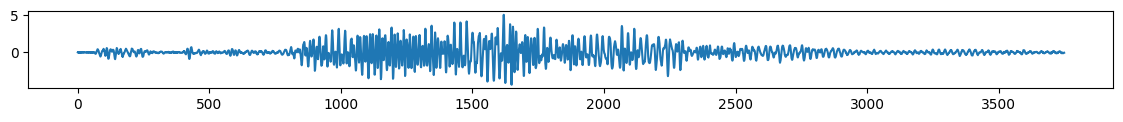

In [173]:
# raw signal
fig = plt.figure(figsize=(14, 1))
plt.plot(sample_std )

In [174]:
len(sample)

3750

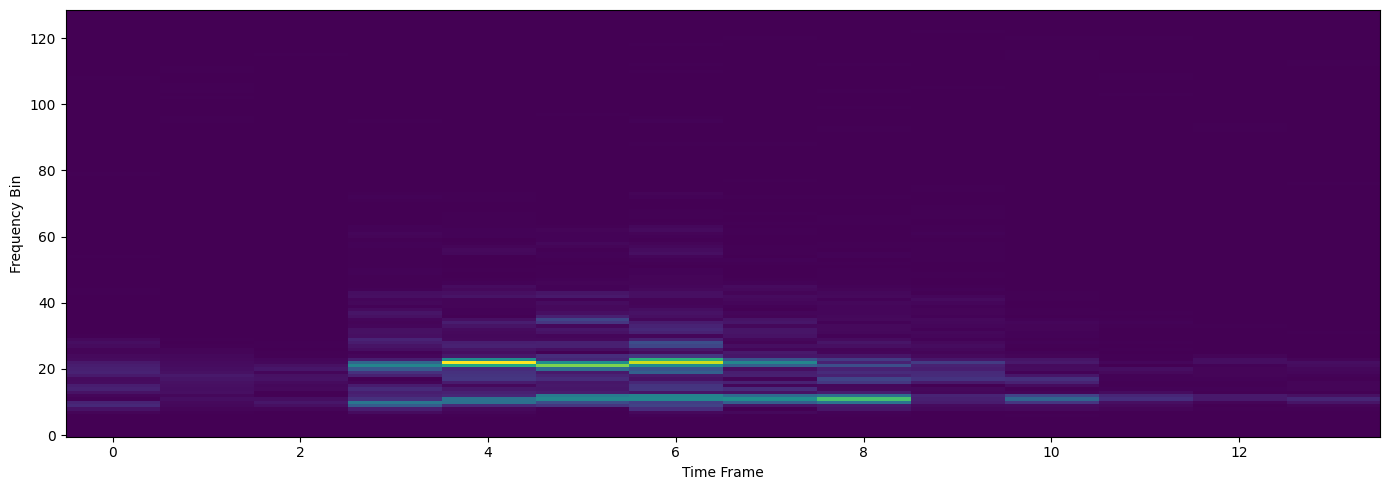

In [189]:

def plot_spectrograms_in_grid(data_list, titles, ncols, nrows, figsize=(14, 5)):
    """
    Plot spectrograms in a grid.
    
    :param data_list: List of spectrogram data to be plotted.
    :param titles: List of titles for each subplot.
    :param ncols: Number of columns in the grid.
    :param nrows: Number of rows in the grid.
    :param figsize: Figure size.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, data, title in zip(np.ravel(axes), data_list, titles):
        ax.imshow(data.numpy().T, aspect='auto', origin='lower')
        ax.set_title(title)
        ax.set_ylabel('Frequency Bin')
        ax.set_xlabel('Time Frame')
    plt.tight_layout()
    plt.show()



plot_spectrograms_in_grid([tf.abs(stft.numpy())], [''], 1, 1)

# Short Fourier Transform (STFT) and Spectrograms

- The Short Fourier Transform (STFT) is a crucial tool for analyzing the frequency content of signals as they change over time.

- The Fourier Transform gives the frequency components of the entire signal; STFT does so for smaller windows of the signal. We can observe how those frequencies evolve.

In [167]:
# short fourier transform

# Compute the STFT taking windows of size 1024 and moving them by 128 samples for each successive window
# since sample rate is 250000 => 4ms, on steps of 0.5ms

stft = tf.signal.stft(sample, frame_length=1024, frame_step=128)

- The spectrogram represents the magnitude of the STFT. Essentially, it displays how the frequencies present in a signal change over time.

- It is a *linear* representation that shows amplitude for each frequency and time point.

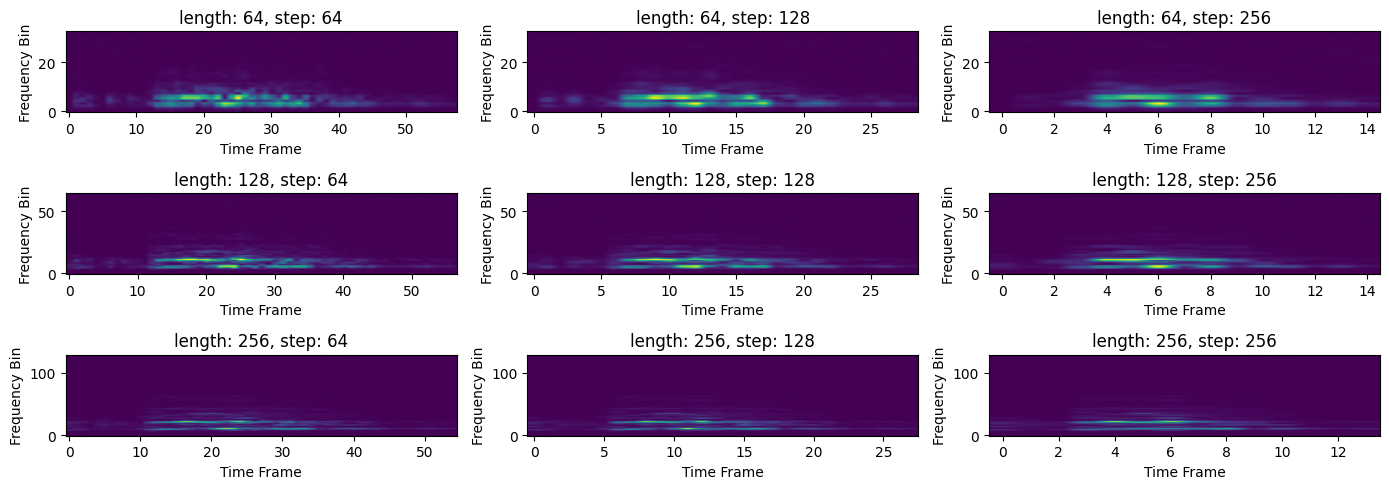

In [190]:
# examples

f_lengths = [64, 128, 256]
f_steps = [64, 128, 256]


examples = []
titles = []
for l in f_lengths:
    for s in f_steps:
    
        stft = tf.signal.stft(sample, frame_length=l, frame_step=s)
        
        #spectrogram
        magnitude_spectrogram = tf.abs(stft)
        
        examples.append( magnitude_spectrogram )
        titles.append(f'length: { l}, step: {s }')
    
plot_spectrograms_in_grid(examples, titles, 3, 3)

- Power-to-decibel spectrogram: converts the magnitude spectrogram (which is in amplitude) to a logarithmic scale (decibels). 
- It shows the power level for each frequency and time point in decibel units; 0 is silence.

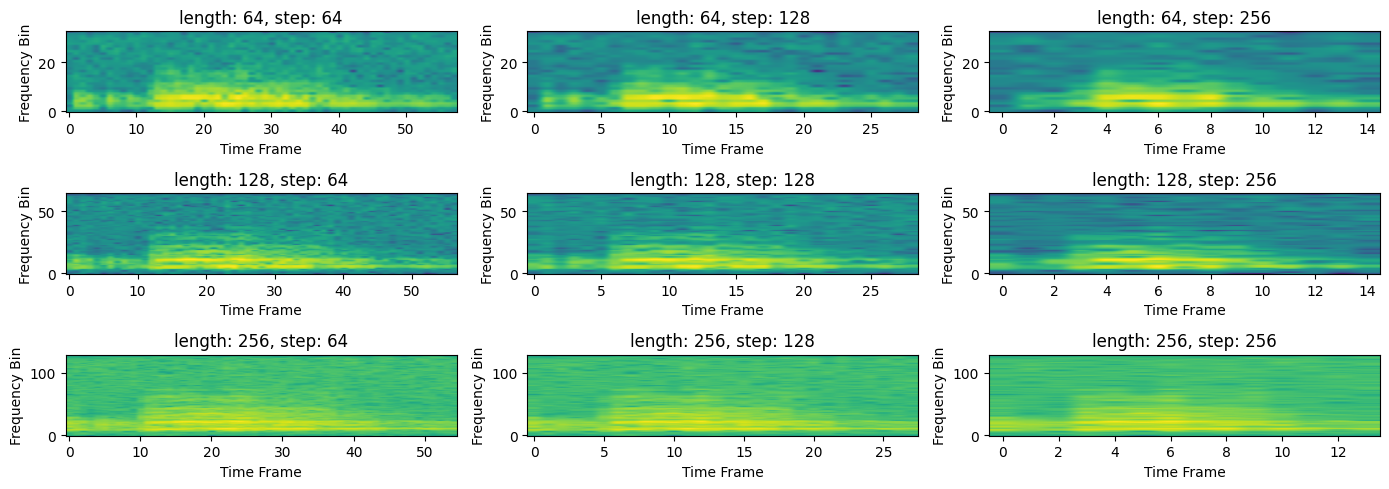

In [191]:

examples = []
titles = []
for l in f_lengths:
    for s in f_steps:
    
        stft = tf.signal.stft(sample, frame_length=l, frame_step=s)
        
        #spectrogram
        magnitude_spectrogram = tf.abs(stft)
        
        # power-to-db
        power_spectrogram = tf.pow(magnitude_spectrogram, 2)
        decibel_spectrogram = 10 * tf.math.log(power_spectrogram)

        
        examples.append( decibel_spectrogram )
        titles.append(f'length: { l}, step: {s }')
    
plot_spectrograms_in_grid(examples, titles, 3, 3)


- Mel-Spectrograms transform the spectrogram where the frequency scale is converted to the mel scale. 
- This scale is designed to mimic the human ear's response to different frequencies: it typically emphasizes low-range frequencies.

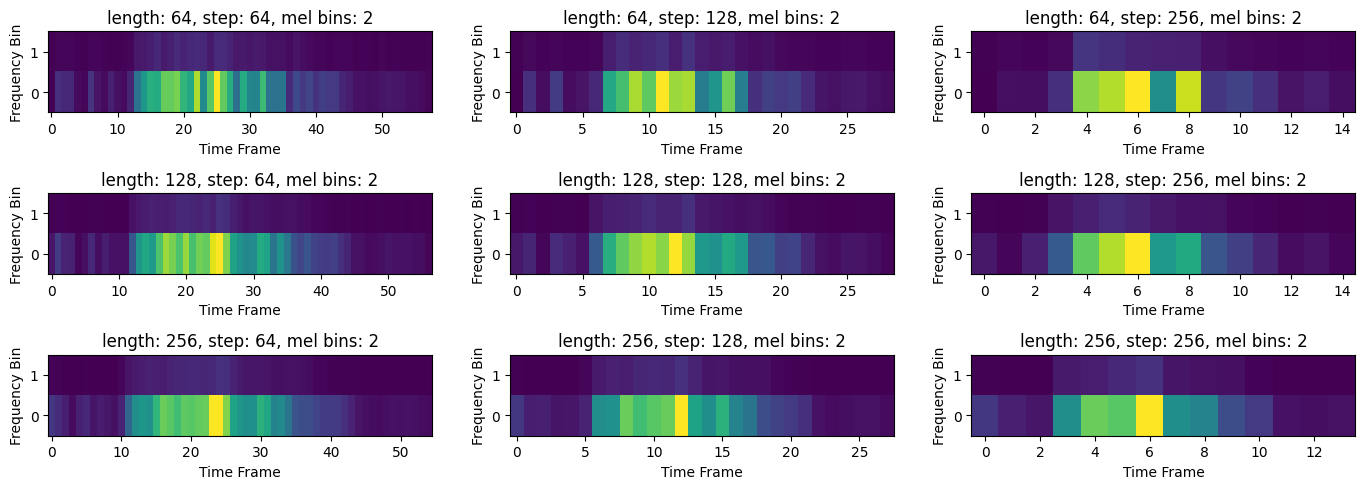

In [201]:
num_mel_bins = 2


examples = []
titles = []
for l in f_lengths:
    for s in f_steps:
    
        stft = tf.signal.stft(sample, frame_length=l, frame_step=s)
        
        #spectrogram
        magnitude_spectrogram = tf.abs(stft)
        
        # power-to-db
        power_spectrogram = tf.pow(magnitude_spectrogram, 2)
        decibel_spectrogram = 10 * tf.math.log(power_spectrogram)
        
        # mel-spectrogram
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, magnitude_spectrogram.shape[-1])
        mel_spectrogram = tf.matmul(magnitude_spectrogram, linear_to_mel_weight_matrix)


        
        examples.append( mel_spectrogram )
        titles.append(f'length: { l}, step: {s }, mel bins: { num_mel_bins }')
    
plot_spectrograms_in_grid(examples, titles, 3, 3)




In [159]:
list(zip(f_lengths, f_steps))

[(512, 256), (1024, 512), (2048, 1024)]

In [138]:
frame_lengths

array([ 512, 1024, 1536, 2048, 2560, 3072, 3584])

# Blackboard

In [124]:
#fourier transform

fourier = tf.signal.rfft(sample)
frequencies = tf.signal.rfft_frequencies(250000)

# Plot the Fourier Transform
plt.figure(figsize=(14, 5))
plt.plot(frequencies.numpy(), tf.abs(fourier.numpy()))
plt.show()

AttributeError: module 'tensorflow._api.v2.signal' has no attribute 'rfft_frequencies'

In [83]:
def fft(audio, rate, num_samples = len(audio)):
    
    # Assume audio is 1-D
    #num_samples = tf.shape(audio)[0]

    rate = 250000

    # If num_samples is odd, tf.signal.rfft will include one additional frequency bin
    # we need to account for this when creating our frequencies array
    if num_samples % 2 == 0:
        num_frequencies = num_samples // 2 + 1
    else:
        num_frequencies = (num_samples + 1) // 2

    # Now we can create an array of frequencies from 0 to the Nyquist frequency
    frequencies = tf.linspace(0., rate // 2, num_frequencies)

    # Now perform the Fourier Transform
    fourier = tf.signal.rfft(audio)
    
    return frequencies.numpy(), tf.abs(fourier).numpy()

In [84]:
frequencies, fourier = fft(sample, 250000, 32)
frequencies.shape, fourier.shape

((17,), (1876,))

ValueError: x and y must have same first dimension, but have shapes (17,) and (1876,)

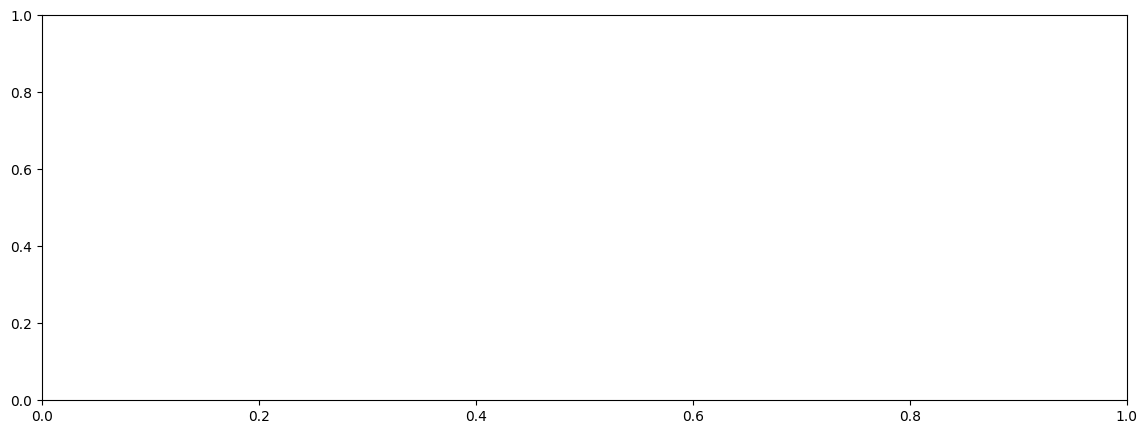

In [81]:
# And plot the Fourier Transform
plt.figure(figsize=(14, 5))

#original sound
frequencies, fourier = fft(sample, 250000, 32)
plt.plot(frequencies, fourier)


#standardized sound
#frequencies, fourier = fft(sample_std, 250000, 1024)
#plt.plot(frequencies, fourier)

plt.title('1D Fourier transform')
plt.legend(['original utterance', 'standardized utterance'])
plt.show()

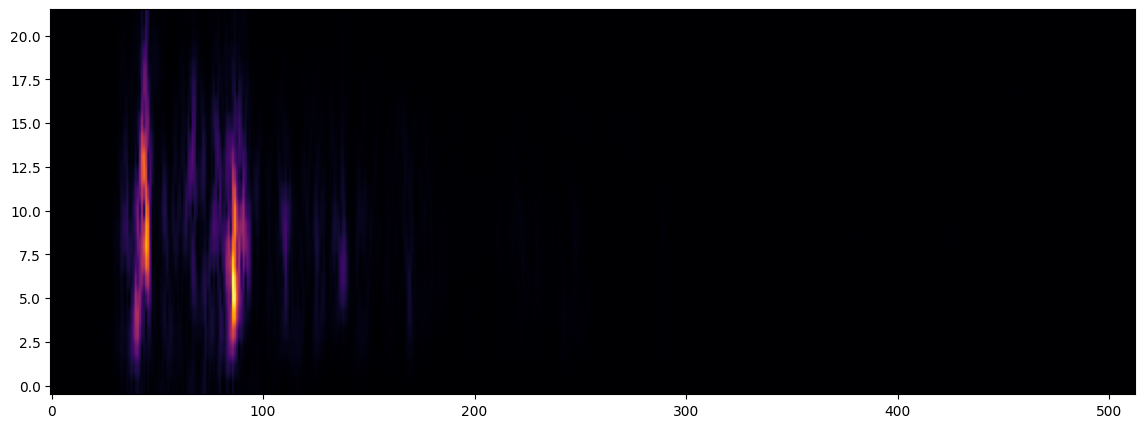

In [151]:
# short fourier transform

stft = tf.signal.stft(sample, frame_length=1024, frame_step=128)

# Plot the STFT
plt.figure(figsize=(14, 5))
plt.imshow(tf.abs(stft.numpy()), aspect='auto', cmap='inferno', origin='lower')
plt.show()

In [152]:
len(sample)

3750

/tmp/ipykernel_3521376/3700554724.py:2: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft)


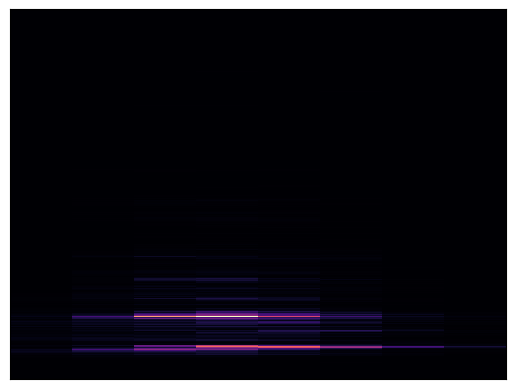

In [122]:
stft = librosa.stft(sample)
librosa.display.specshow(stft)

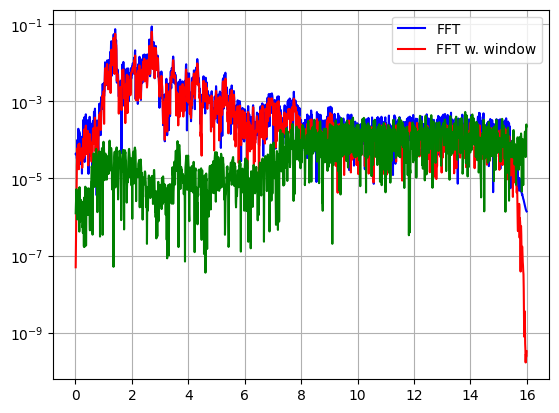

In [91]:
from scipy.fft import fft, fftfreq

import numpy as np

# Number of sample points

N = sample.shape[0]

# sample spacing

T = 1.0 / 32.0

x = np.linspace(0.0, N*T, N, endpoint=True)

y = sample

yf = fft(y)

from scipy.signal.windows import blackman

w = blackman(N)

ywf = fft(y*w)

xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt



plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')

plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')

plt.semilogy(xf[1:N//2], 2.0/N * np.abs(y[1:N//2]), '-g')

plt.legend(['FFT', 'FFT w. window'])

plt.grid()

plt.show()

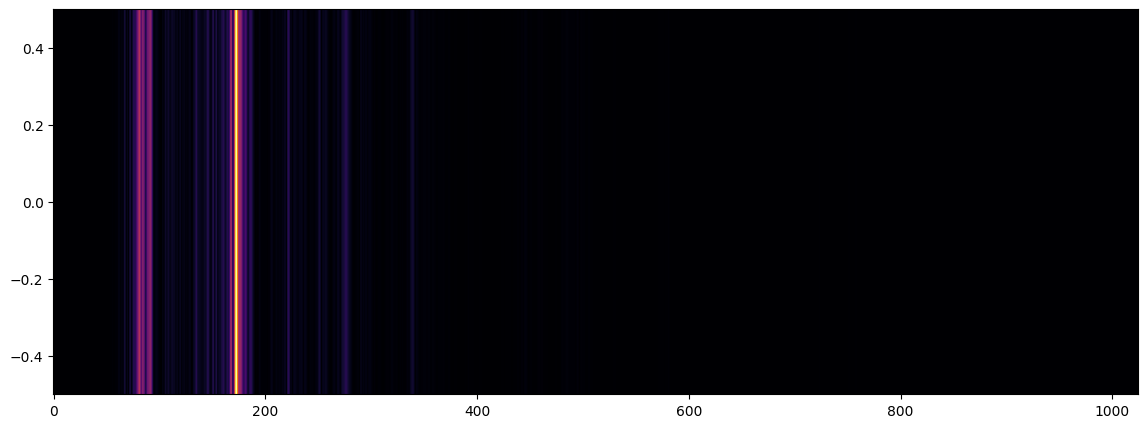

In [108]:
# Perform the STFT
stft = tf.signal.stft(audio, frame_length=2048, frame_step=4096)

# Plot the STFT
plt.figure(figsize=(14, 5))
plt.imshow(tf.abs(stft.numpy()), aspect='auto', cmap='inferno', origin='lower')
plt.show()

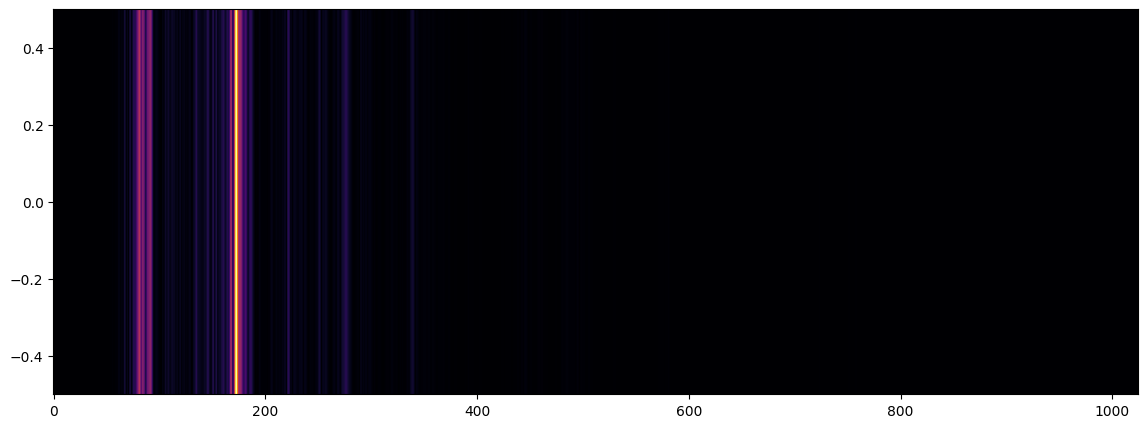

In [109]:
# Compute the magnitude spectrogram
magnitude_spectrogram = tf.abs(stft)

# Plot the magnitude spectrogram
plt.figure(figsize=(14, 5))
plt.imshow(magnitude_spectrogram.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.show()

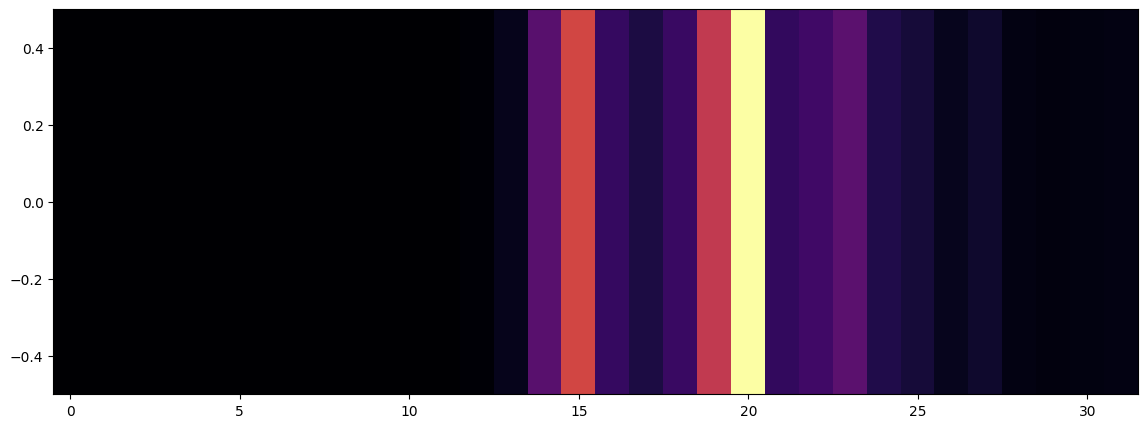

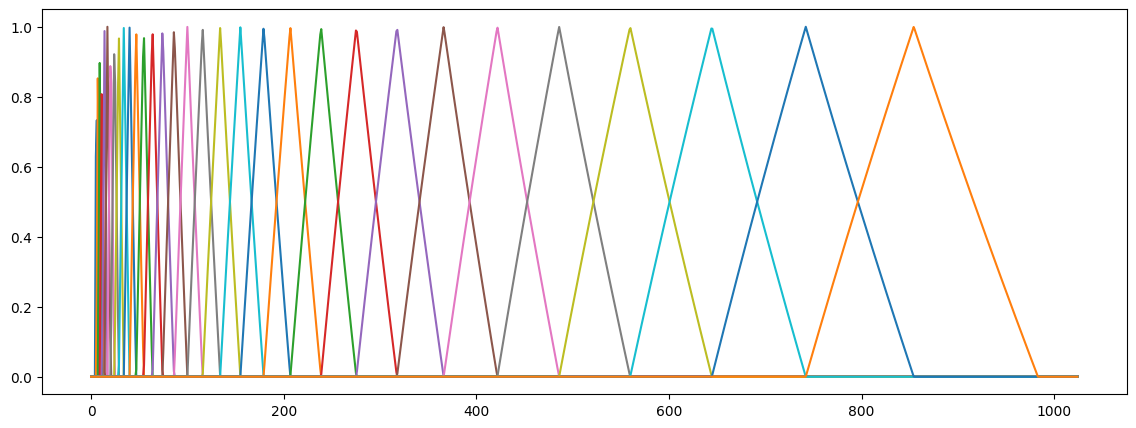

In [110]:
# Define the custom MEL filterbank
num_mel_bins = 32
num_spectrogram_bins = magnitude_spectrogram.shape[-1]
lower_edge_hertz, upper_edge_hertz = 500.0, 120000.0  # Modify as needed

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)

# Compute the mel spectrogram
mel_spectrogram = tf.tensordot(magnitude_spectrogram, linear_to_mel_weight_matrix, 1)

# Plot the mel spectrogram
plt.figure(figsize=(14, 5))
plt.imshow(mel_spectrogram.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.show()

# Plot the MEL-filterbank
plt.figure(figsize=(14, 5))
plt.plot(linear_to_mel_weight_matrix.numpy())
plt.show()

